In [1]:
import ee
import geemap
import math
geemap.set_proxy(port=7890)

In [2]:
ee.Initialize()

In [3]:
#This example demonstrates the use of the Landsat 8 Collection 2, Level 2
#QA_PIXEL band (CFMask) to mask unwanted pixels.
def maskL789sr(image):
#// Bit 0 - Fill
#// Bit 1 - Dilated Cloud
#// Bit 2 - Cirrus
# // Bit 3 - Cloud
# // Bit 4 - Cloud Shadow
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0);
  saturationMask = image.select('QA_RADSAT').eq(0);

  #Apply the scaling factors to the appropriate bands.
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);

  #Replace the original bands with the scaled ones and apply the masks.
  return image.addBands(opticalBands, None, True)\
      .addBands(thermalBands, None, True)\
      .updateMask(qaMask)\
      .updateMask(saturationMask)

def maskS2clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .copyProperties(image, ["system:time_start"])

In [4]:
geom_shp = r"E:\项目\论文\B因子计算\延河流域矢量图\yh.shp"
# 将矢量图形文件转换为Earth Engine中的几何对象
roi = geemap.shp_to_ee(geom_shp).geometry()

In [5]:
def s2_ndiv(img):
    return img.normalizedDifference(["B8", "B4"]).rename("s2NDVI")
def l8_ndiv(img):
    return img.normalizedDifference(["SR_B5","SR_B4"]).rename("l8NDVI")
def l7_ndiv(img):
    return img.normalizedDifference(["SR_B4","SR_B3"]).rename("l7NDVI")

In [6]:
MODIS_m = ee.ImageCollection('MODIS/MOD09GA_006_NDVI')\
                    .filter(ee.Filter.calendarRange(2019,2021,'year'))\
                    
modisn = MODIS_m.max().clip(roi).multiply(10000).toInt()  # .reproject('EPSG:4326', scale=60)


In [7]:

s2_m = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filter(ee.Filter.calendarRange(2019,2021,'year'))\
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))\
                    .filterBounds(roi)\
                    .map(maskS2clouds)\
                    .map(s2_ndiv)
s2n = s2_m.max().clip(roi).multiply(10000).toInt()


In [8]:

l8_m = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
                    .filter(ee.Filter.calendarRange(2019,2021,'year'))\
                    .filter(ee.Filter.lt('CLOUD_COVER',20))\
                    .filterBounds(roi)\
                    .map(maskL789sr)\
                    .map(l8_ndiv)              
l8n = l8_m.max().clip(roi).multiply(10000).toInt()


In [9]:

l7_m = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")\
                    .filter(ee.Filter.calendarRange(2019,2021,'year'))\
                    .filter(ee.Filter.lt('CLOUD_COVER',20))\
                    .filterBounds(roi)\
                    .map(maskL789sr)\
                    .map(l7_ndiv)
                                       
l7n = l7_m.max().clip(roi).multiply(10000).toInt()


In [10]:
collection = ee.ImageCollection.fromImages([modisn , s2n ,l7n, l8n]);
img = collection.toBands()
img = img.select(img.bandNames(),['modis','s2','l7','l8'])

In [12]:
corrValue_sm = img.select(['modis','s2']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),1000)
corrValue_sm

In [13]:
corrValue_sl7 = img.select(['s2','l7']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),600)
corrValue_sl7

In [14]:
corrValue_sl8 = img.select(['s2','l8']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),600)
corrValue_sl8

In [15]:
corrValue_l8l7 = img.select(['l8','l7']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),600)
corrValue_l8l7

In [16]:
corrValue_l8m = img.select(['l8','modis']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),1000)
corrValue_l8m

In [17]:
corrValue_l7m = img.select(['modis','l7']).reduceRegion(ee.Reducer.pearsonsCorrelation(),img.geometry(),1000)
corrValue_l7m

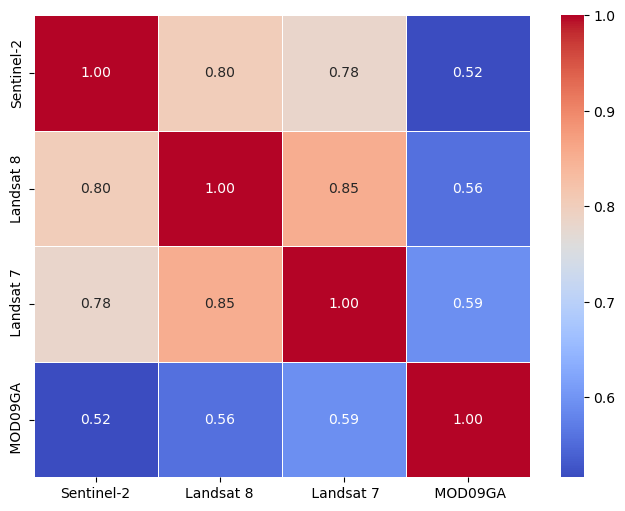

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建相关性矩阵
correlation_matrix = [[1.0, 0.8034078929120602, 0.782593904733304, 0.5163145277884212],
                      [0.8034078929120602, 1.0, 0.8531469229897043, 0.5568174235705813],
                      [0.782593904733304, 0.8531469229897043, 1.0, 0.5937401823063564],
                      [0.5163145277884212, 0.5568174235705813, 0.5937401823063564, 1.0]]

# 将相关性矩阵转化为DataFrame
import pandas as pd
df = pd.DataFrame(correlation_matrix, columns=["Sentinel-2","Landsat 8"," Landsat 7"," MOD09GA"], index=["Sentinel-2","Landsat 8"," Landsat 7"," MOD09GA"])

# 创建热力图
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# # 添加标题
# plt.title('相关性热力图')

# 显示热力图
plt.show()
